# Based on Jung et al. 2020

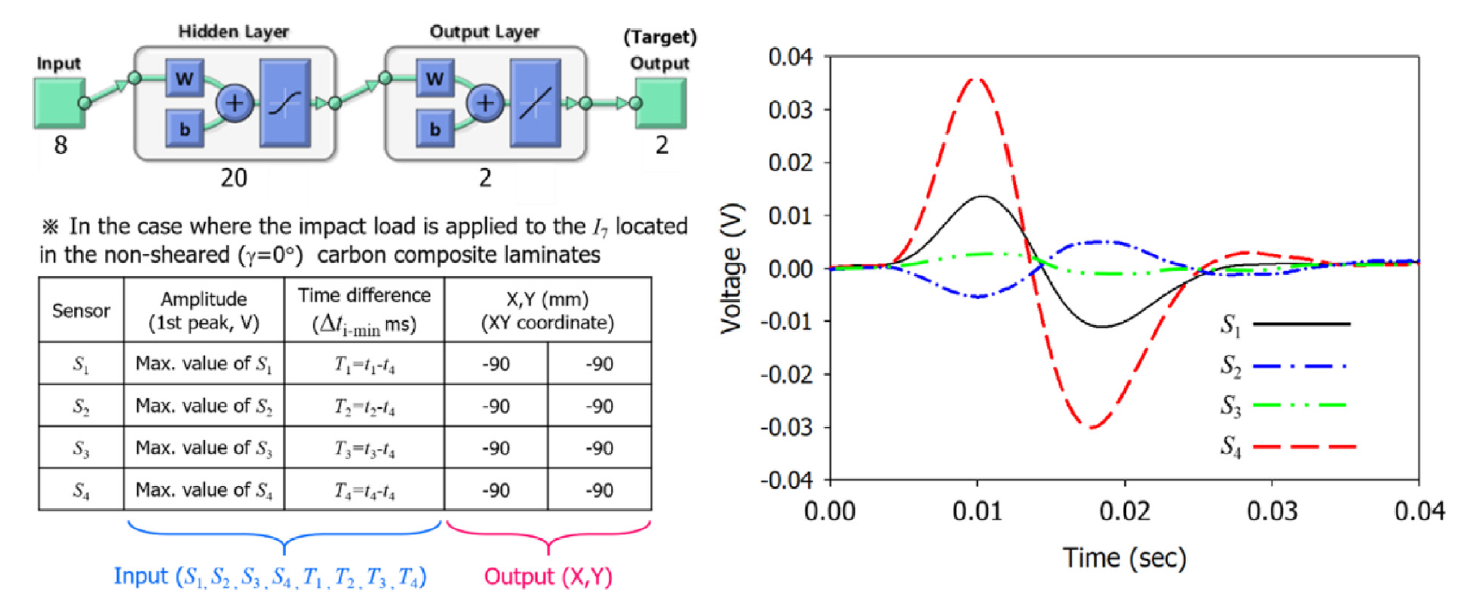

In [16]:
import os

import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy.typing as npt
from typing import Callable

current_device = torch.cuda.current_device()
print(torch.cuda.get_device_name(current_device))

NVIDIA GeForce GTX 960


In [17]:
from nn_helper import MyDataset, get_dataset

train_dataset = MyDataset("data/dataset_train_2.csv")
test_dataset = MyDataset("data/dataset_test_2.csv")

In [18]:
from nn_models import NNJungEtAl

num_sensors = 6
input_size = num_sensors * 2
model = NNJungEtAl(input_size)

batch_size = 8
model.info(batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
NNJungEtAl                               [8, 2]                    --
├─Linear: 1-1                            [8, 20]                   260
├─Linear: 1-2                            [8, 2]                    42
Total params: 302
Trainable params: 302
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


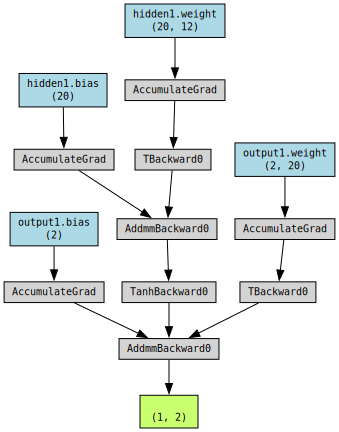

In [19]:
model.render()

Loss at epoch 000: train_loss = 1190.904488 / val_loss = 980.498769
Loss at epoch 010: train_loss = 115.163618 / val_loss = 42.204870
Loss at epoch 020: train_loss = 107.282735 / val_loss = 20.835248
Loss at epoch 030: train_loss = 97.069054 / val_loss = 14.364823
Loss at epoch 040: train_loss = 87.880208 / val_loss = 31.543495
Loss at epoch 050: train_loss = 85.124203 / val_loss = 32.647371
Loss at epoch 060: train_loss = 84.704522 / val_loss = 28.655168
Loss at epoch 070: train_loss = 86.164085 / val_loss = 21.342196
Loss at epoch 080: train_loss = 84.504156 / val_loss = 21.425906
Loss at epoch 090: train_loss = 82.176441 / val_loss = 26.530921
Loss at epoch 100: train_loss = 78.100244 / val_loss = 39.811728
Loss at epoch 110: train_loss = 85.751086 / val_loss = 10.052064
Loss at epoch 120: train_loss = 80.693882 / val_loss = 26.513406
Loss at epoch 130: train_loss = 82.789730 / val_loss = 16.994425
Loss at epoch 140: train_loss = 85.401632 / val_loss = 7.613559
Loss at epoch 150: tr

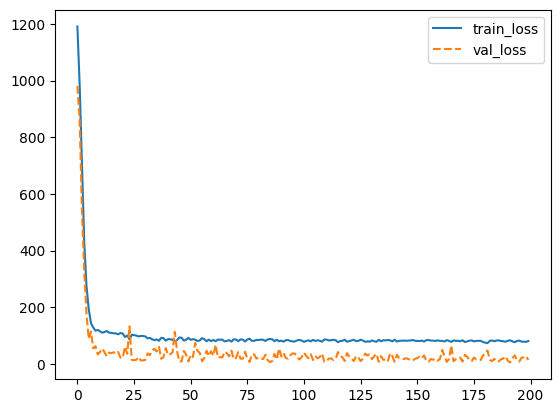

In [20]:
from nn_train import train_model

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=2e-2)
history = train_model(model, train_dataset, loss_fn, optimizer, current_device, epochs=200, validation_split=0.2, batch_size=batch_size, lambda1=0.25, lambda2=0.0085)
#l1=0.05, l2=0.02
#l1=0.023, l2=0.011

# Plot history
plt.figure()

epochs = range(len(history["train_loss"]))
plt_list = [["train_loss", "-"], ["val_loss", "--"]]

for name, style in plt_list:
    plt.plot(epochs, history[name], style, label=name)
plt.legend(loc="best")

In [23]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import tempfile

from nn_train import train_epoch

def train_hyperparameter_search(config: dict, checkpoint_dir: str = None):
    train_dataset = MyDataset(r"T:\Research_Exchange_Matthias\02_Project\03_code\scf_nn_tests\data\dataset_train_2.csv") #must be an absolute path!
    model = NNJungEtAl(6*2, hidden_size=config["hidden_size"])
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adamax(model.parameters(), lr=config["lr"])

    model.to(current_device)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    for epoch in range(200):
        met = train_epoch(model, train_dataset, loss_fn, optimizer, current_device, 0.2, config["batch_size"], config["l1"], config["l2"])

        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if (epoch + 1) % 10 == 0:
                # This saves the model to the trial directory
                torch.save(model.state_dict(), os.path.join(temp_checkpoint_dir, "tuning_model.pth"))
                checkpoint = tune.Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Tune
            tune.report({"loss": met["val_loss"]}, checkpoint=checkpoint)

2025-04-17 14:31:20,988	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-17 14:31:21,881	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [24]:
config = {
    #"hidden_size": tune.sample_from(lambda _: 2 ** np.random.randint(4, 6+1)),
    "hidden_size": 20,
    #"epochs": tune.qrandint(20, 200, 10),
    "l1": tune.loguniform(5e-3, 5e-1),
    "l2": tune.loguniform(5e-3, 5e-1),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([4, 8, 16, 32])
}

scheduler = ASHAScheduler(metric="loss", mode="min", max_t=200, grace_period=3, reduction_factor=2)
reporter = CLIReporter(
    parameter_columns=["hidden_size", "l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "training_iteration"]
)

In [ ]:
def short_dirname(trial):
    return "trial_" + str(trial.trial_id)

result = tune.run(
    train_hyperparameter_search,
    resources_per_trial={"cpu": 4, "gpu": 1},
    config=config,
    num_samples=30,
    scheduler=scheduler, progress_reporter=reporter, trial_dirname_creator=short_dirname
)

In [26]:
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result["loss"]}")

best_trained_model = NNJungEtAl(6*2, hidden_size=best_trial.config["hidden_size"])
best_trained_model.to(current_device)

with best_trial.checkpoint.as_directory() as checkpoint_dir: 
    model_state = torch.load(os.path.join(checkpoint_dir, "tuning_model.pth"))
    best_trained_model.load_state_dict(model_state)

#best_trained_model.state_dict()

#torch.save(best_trained_model.state_dict(), "models/tuned_model_4.pt")
#torch.save(best_trial.config, "models/tuned_model_config_4.pkl")

Best trial config: {'hidden_size': 20, 'l1': 0.11824077958528113, 'l2': 0.032799276252105866, 'lr': 0.008805854602693374, 'batch_size': 8}
Best trial final validation loss: 7.166505306959152


## Testing

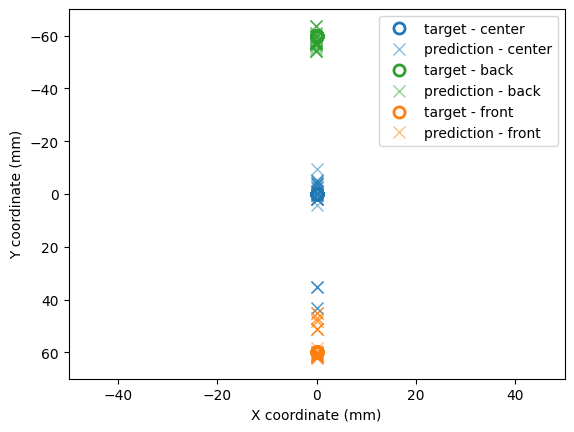

In [27]:
from nn_helper import LocationsContainer, locations
from torch.utils.data import DataLoader
from torch import Tensor

def test_model(model: torch.nn.Module, dataset: torch.utils.data.Dataset, locations: LocationsContainer, error_fun: Callable[[npt.ArrayLike, npt.ArrayLike], float], device: str = "cpu") -> tuple[plt.Figure, plt.Axes, dict]:
    model.eval()
    model = model.to(device)

    fig, ax = plt.subplots()
    errors = {label: [] for label in locations.get_labels()}

    with torch.no_grad():
        for x, y in DataLoader(dataset, shuffle=True):
            x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
            y_np = y.reshape((2,)).numpy()

            y_predict: Tensor = model(x)
            y_pred_np = y_predict.detach().reshape((2,)).numpy()
            location = locations.from_xy(y_np[0], y_np[1])

            ax.plot(y_np[0], y_np[1], "o", mfc="none", mew=2, markersize=8, color=location.color, label="target - " + location.label)
            ax.plot(y_pred_np[0], y_pred_np[1], "x", markersize=8, color=location.color, label="prediction - " + location.label, alpha=0.5)

            error = error_fun(y_pred_np, y_np)
            errors[location.label].append(error)

            #ax.yaxis.set_inverted(True)
            ax.set_xlim((-50, 50))
            ax.set_ylim((70, -70)) #inverted!

            ax.set_xlabel("X coordinate (mm)")
            ax.set_ylabel("Y coordinate (mm)")

            # force unique labels
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys())

    return fig, ax, errors

#model = best_trained_model
def error_fun(prediction: npt.ArrayLike, target: npt.ArrayLike) -> float:
    return np.linalg.norm(target - prediction)

fig, ax, errors = test_model(model, test_dataset, locations, error_fun=error_fun)

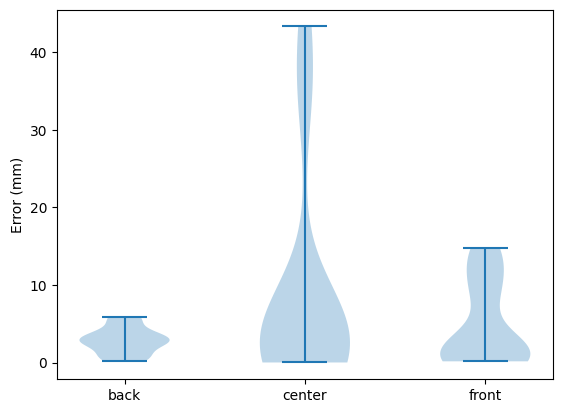

In [28]:
def plot_violins_from_error(errors: dict, threshold: float = 100) -> tuple[plt.Figure, plt.Axes]:
    #ToDo clean up this mess!

    errors = dict(sorted(errors.items())) # sort so that keys are in alphabetical order

    fig, ax = plt.subplots()

    all_data = [v for v in errors.values()]
    removed_count = sum(1 for cat in all_data for val in cat if val > threshold) #check how many values will be removed

    if removed_count > 0:
        print(f"Removed {removed_count} values exceeding the threshold of {threshold}")
        all_data = [[val for val in cat if val <= threshold] for cat in all_data] #hack for quick thresholding
        #actually remove them

    ax.violinplot(all_data)
    ax.set_xticks([i + 1 for i in range(len(all_data))], labels=errors.keys())
    ax.set_ylabel("Error (mm)")

    return fig, ax

fig, ax = plot_violins_from_error(errors, 100)

[ 6.8954694e-05 -8.8565378e-04  5.5201055e-04  4.6374099e-04
 -2.8585791e-04  6.9067546e-04 -1.2163933e-01  2.5197214e-02
 -3.7914969e-02 -1.9329328e-02 -9.4159827e-02 -6.9287757e-04]


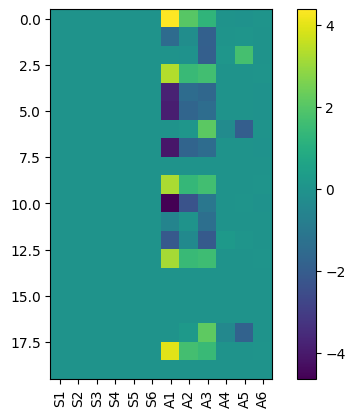

In [ ]:
w1 = model.state_dict()["hidden1.weight"].numpy()
#w1.shape
print(np.mean(w1, axis=0)) #expect index 0 to be close to 0 as the input in the training data is always 0 if no "data_augmentation" is used

plt.figure()
plt.imshow(w1, interpolation=None)
plt.xticks(np.arange(0, w1.shape[1]), ["S1", "S2", "S3", "S4", "S5", "S6", "A1", "A2", "A3", "A4", "A5", "A6"], rotation=90)
plt.colorbar()

In [ ]:
return
# Prevents running cells that save model on accident when running all

SyntaxError: 'return' outside function (45999671.py, line 1)

In [ ]:
torch.save(model.state_dict(), "models/model_test.pt")

In [ ]:
loaded_model = MyNN(input_size)
loaded_model.load_state_dict(torch.load("models/model_test.pt", weights_only=True))
loaded_model.eval()

MyNN(
  (hidden1): Linear(in_features=12, out_features=20, bias=True)
  (output1): Linear(in_features=20, out_features=2, bias=True)
)